In [1]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score

import pandas as pd
from matplotlib import pyplot as plt 

import pickle

import mlflow
import mlflow.sklearn
import shutil

In [2]:
import tensorflow as tf
import keras
from keras import models, layers
import matplotlib.pyplot as plt

print(keras.__version__)

/home/ec2-user/.local/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/home/ec2-user/.local/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/home/ec2-user/.local/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/home/ec2-user/.local/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.

2.2.4


/home/ec2-user/.local/lib/python3.7/site-packages/tensorboard/compat/tensorflow_stub/dtypes.py:541: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/home/ec2-user/.local/lib/python3.7/site-packages/tensorboard/compat/tensorflow_stub/dtypes.py:542: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/home/ec2-user/.local/lib/python3.7/site-packages/tensorboard/compat/tensorflow_stub/dtypes.py:543: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/home/ec2-user/.local/lib/python3.7/site-packages/tensorboard/co

In [3]:
gamesDF = pd.read_csv('https://github.com/bgweber/Twitch/raw/master/Recommendations/games-expand.csv')
gamesDF.head()

,G1,G2,G3,G4,G5,G6,G7,G8,G9,G10,label
0,0,0,0,1,0,0,0,0,0,0,0
1,0,0,0,0,1,0,0,0,0,0,0
2,0,0,1,0,0,0,0,0,0,0,0
3,0,0,1,0,0,1,1,0,0,1,1
4,0,0,1,0,1,1,0,1,1,0,1


# Train with sklearn

In [4]:
x_train, x_test, y_train, y_test = train_test_split(gamesDF.drop(['label'], axis=1), 
                                                    gamesDF['label'],
                                                    test_size=0.3)

model = LogisticRegression()
model.fit(x_train, y_train)

print("Acc: " + str(model.score(x_test, y_test)))
print("ROC: " + str(roc_auc_score(y_test, model.predict_proba(x_test)[:, 1])))

Acc: 0.8773282887077998
ROC: 0.7570392608235927


# Export with sklearn

In [8]:
df = pd.read_csv('https://github.com/bgweber/Twitch/raw/master/Recommendations/games-expand.csv')

x = df.drop(['label'], axis=1)
y = df['label']

model = LogisticRegression()
model.fit(x, y)

LogisticRegression()

In [ ]:
pickle.dump(model, open('logit.pkl', 'wb'))
model.predict_proba(x)

In [ ]:
model_path = 'models/logit_games_v1'
#shutil.rmtree(model_path)
mlflow.sklearn.save_model(model, model_path)

In [ ]:
loaded = mlflow.sklearn.load_model(model_path)
loaded.predict_proba(x)

# Train with Keras

In [4]:
x_train, x_test, y_train, y_test = train_test_split(gamesDF.drop(['label'], axis=1), 
                                                    gamesDF['label'],
                                                    test_size=0.3)

model = models.Sequential()
model.add(layers.Dense(64, activation='relu', input_shape=(10,)))
model.add(layers.Dropout(0.1))
model.add(layers.Dense(64, activation='relu'))
model.add(layers.Dense(1, activation='sigmoid'))

def auc(y_true, y_pred):
    auc = tf.metrics.auc(y_true, y_pred)[1]
    keras.backend.get_session().run(tf.local_variables_initializer())
    return auc

model.compile(optimizer='rmsprop', loss='binary_crossentropy', metrics=[auc])
history = model.fit(x_train, y_train, epochs=100, batch_size=100, validation_split=0.2, verbose=0)





Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
Instructions for updating:
Deprecated in favor of operator or tf.math.divide.


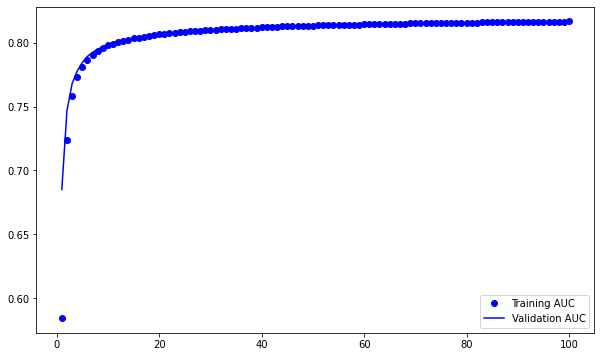

ROC: 0.8167289147832202


In [5]:
loss = history.history['auc']
val_loss = history.history['val_auc']
epochs = range(1, len(loss) + 1)

plt.figure(figsize=(10, 6))
plt.plot(epochs, loss, 'bo', label='Training AUC')
plt.plot(epochs, val_loss, 'b', label='Validation AUC')
plt.legend()
plt.show()

results = model.evaluate(x_test, y_test, verbose=0)
print('ROC: ' + str(results[1]))

# Export models keras

In [7]:
df = pd.read_csv('https://github.com/bgweber/Twitch/raw/master/Recommendations/games-expand.csv')

x = df.drop(['label'], axis=1)
y = df['label']

In [8]:
from keras.models import load_model
model.save("games.h5")

model = load_model('games.h5', custom_objects={'auc': auc})
model.evaluate(x, y, verbose=0)

[0.3082834490878018, 0.8048968716131967]

In [10]:
import mlflow.keras
model_path = 'models/keras_games_v1'
shutil.rmtree(model_path)

mlflow.keras.save_model(model, model_path)

loaded = mlflow.keras.load_model(model_path, custom_objects={'auc': auc})
loaded.evaluate(x, y, verbose=0)

[0.3082834490878018, 0.8048968716131967]

# Send request to webservice

In [12]:
import requests

new_row = {'G1': 0, 'G2': 0, 'G3': 0, 'G4': 0, 'G5': 0,
           'G6': 0, 'G7': 0, 'G8': 0, 'G9': 0, 'G10': 1}

result = requests.get('http://127.0.0.1:5000/', params=new_row)
print(result.json()['response'])

0.28109238
